In [1]:
from pathlib import Path
from time import time
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import wisardpkg as wp
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from tqdm import tqdm
import matplotlib.pyplot as plt

from feature_resizing import WisardFeatureResizer
from thermometer_encoder import ThermometerEncoder
from wisard_classifier import WisardClassifier

dataset_dir = Path('UCI HAR Dataset')

def plot_confusion_matrix(y_true, y_pred, display_labels=None, normalize='true'):
    if display_labels is None:
        display_labels = np.unique(y_true)
            
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    disp.plot(xticks_rotation=90)
    disp.ax_.grid(False)


def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    training_accuracy = accuracy_score(y_train.astype(str), pred_train.astype(str))
    test_accuracy = accuracy_score(y_test.astype(str), pred_test.astype(str))

    print(f'Training Accuracy: {training_accuracy:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

    display_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS',
                      'SITTING', 'STANDING', 'LAYING']
    plot_confusion_matrix(y_test.astype(str), pred_test.astype(str), 
                          display_labels=display_labels)
    plot_confusion_matrix(y_test.astype(str), pred_test.astype(str), 
                          display_labels=display_labels,
                          normalize=None)

# Loading Data

## Total Body acceleration

In [2]:
train_total_acc_x = pd.read_csv(dataset_dir/'train/Inertial Signals/total_acc_x_train.txt', 
                          header=None, delim_whitespace=True).values
train_total_acc_y = pd.read_csv(dataset_dir/'train/Inertial Signals/total_acc_y_train.txt', 
                          header=None, delim_whitespace=True).values
train_total_acc_z = pd.read_csv(dataset_dir/'train/Inertial Signals/total_acc_z_train.txt', 
                          header=None, delim_whitespace=True).values

test_total_acc_x = pd.read_csv(dataset_dir/'test/Inertial Signals/total_acc_x_test.txt', 
                          header=None, delim_whitespace=True).values
test_total_acc_y = pd.read_csv(dataset_dir/'test/Inertial Signals/total_acc_y_test.txt', 
                          header=None, delim_whitespace=True).values
test_total_acc_z = pd.read_csv(dataset_dir/'test/Inertial Signals/total_acc_z_test.txt', 
                          header=None, delim_whitespace=True).values

In [3]:
train_total_acc_x.shape

(7352, 128)

In [4]:
test_total_acc_x.shape

(2947, 128)

## Estimated Body acceleration

In [5]:
train_body_acc_x = pd.read_csv(dataset_dir/'train/Inertial Signals/body_acc_x_train.txt', 
                          header=None, delim_whitespace=True).values
train_body_acc_y = pd.read_csv(dataset_dir/'train/Inertial Signals/body_acc_y_train.txt', 
                          header=None, delim_whitespace=True).values
train_body_acc_z = pd.read_csv(dataset_dir/'train/Inertial Signals/body_acc_z_train.txt', 
                          header=None, delim_whitespace=True).values

test_body_acc_x = pd.read_csv(dataset_dir/'test/Inertial Signals/body_acc_x_test.txt', 
                          header=None, delim_whitespace=True).values
test_body_acc_y = pd.read_csv(dataset_dir/'test/Inertial Signals/body_acc_y_test.txt', 
                          header=None, delim_whitespace=True).values
test_body_acc_z = pd.read_csv(dataset_dir/'test/Inertial Signals/body_acc_z_test.txt', 
                          header=None, delim_whitespace=True).values

In [6]:
train_body_acc_x.shape

(7352, 128)

In [7]:
test_body_acc_x.shape

(2947, 128)

## Triaxial Angular velocity from the gyroscope

In [8]:
train_gyro_x = pd.read_csv(dataset_dir/'train/Inertial Signals/body_gyro_x_train.txt', 
                          header=None, delim_whitespace=True).values
train_gyro_y = pd.read_csv(dataset_dir/'train/Inertial Signals/body_gyro_y_train.txt', 
                          header=None, delim_whitespace=True).values
train_gyro_z = pd.read_csv(dataset_dir/'train/Inertial Signals/body_gyro_z_train.txt', 
                          header=None, delim_whitespace=True).values

test_gyro_x = pd.read_csv(dataset_dir/'test/Inertial Signals/body_gyro_x_test.txt', 
                          header=None, delim_whitespace=True).values
test_gyro_y = pd.read_csv(dataset_dir/'test/Inertial Signals/body_gyro_y_test.txt', 
                          header=None, delim_whitespace=True).values
test_gyro_z = pd.read_csv(dataset_dir/'test/Inertial Signals/body_gyro_z_test.txt', 
                          header=None, delim_whitespace=True).values

In [9]:
train_gyro_x.shape

(7352, 128)

In [10]:
test_gyro_x.shape

(2947, 128)

## Engineered features

In [11]:
train_eng = pd.read_csv(dataset_dir/'train/X_train.txt', 
                        header=None, delim_whitespace=True).values

test_eng = pd.read_csv(dataset_dir/'test/X_test.txt', 
                       header=None, delim_whitespace=True).values

In [12]:
train_eng.shape

(7352, 561)

In [13]:
test_eng.shape

(2947, 561)

## Subjects

In [14]:
train_subjects = pd.read_csv(dataset_dir/'train/subject_train.txt', delim_whitespace=True, header=None).values

train_subjects.shape

(7352, 1)

In [15]:
test_subjects = pd.read_csv(dataset_dir/'test/subject_test.txt', delim_whitespace=True, header=None).values

test_subjects.shape

(2947, 1)

## Labels

There are 6 types os activites to be recognized in the dataset:

1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

In [16]:
train_labels = pd.read_csv(dataset_dir/'train/y_train.txt', delim_whitespace=True, header=None).values

train_labels.shape

(7352, 1)

In [17]:
test_labels = pd.read_csv(dataset_dir/'test/y_test.txt', delim_whitespace=True, header=None).values

test_labels.shape

(2947, 1)

In [18]:
pd.DataFrame(np.concatenate((train_labels, test_labels), axis=0)).value_counts()

6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
dtype: int64

# 2. Data transformation

The sampled signals will be transformed to a 2D matrix where each column represents a different feature and each row represents the subsequent timestep value of each feature. So, the final array will have indexes representing [sample, timestep, feature].

In [19]:
def group_signals(signals_list):
    signals_set = list()
    for signal in signals_list:
        signals_set.append(signal)
    signals_set = np.dstack(signals_set)
    return signals_set

In [20]:
train_signals = [train_total_acc_x, train_total_acc_y, train_total_acc_z,
                 train_body_acc_x, train_body_acc_y, train_body_acc_z,
                 train_gyro_x, train_gyro_y, train_gyro_z]

train_set_signals = group_signals(train_signals)
train_set_signals.shape

(7352, 128, 9)

In [21]:
test_signals = [test_total_acc_x, test_total_acc_y, test_total_acc_z,
                 test_body_acc_x, test_body_acc_y, test_body_acc_z,
                 test_gyro_x, test_gyro_y, test_gyro_z]
test_set_signals = group_signals(test_signals)
test_set_signals.shape

(2947, 128, 9)

# 3. Model training

## 3.1. Model 1: WiSARD

This model uses Thermometer encoding and the enginnered features to make the prediction.

In [22]:
def cross_validation_model1(X, y, n_splits=5, addressSize=[50], thermometer_size=[5], bleachingActivated=[True], 
                            thermometer_columns=None):
    grid_search_results = []
    best_params = None
    best_accuracy = -1
    
    if not thermometer_columns:
        thermometer_columns = list(range(X.shape[1]))
    
    param_grid_dict = dict()
    param_grid_dict['thermometer_size'] = thermometer_size
    param_grid_dict['addressSize'] = addressSize
    param_grid_dict['bleachingActivated'] = bleachingActivated
    
    skf = StratifiedKFold(n_splits=n_splits)
    
    param_grid = ParameterGrid(param_grid_dict)
    
    param_grid_combinations = len(list(param_grid))
    n_combs = n_splits * param_grid_combinations
    progress = tqdm(total=n_combs, position=0, leave=True)
    
    for params in param_grid:
        print(params)
        training_time = []
        training_prediction_time = []
        validation_prediction_time = []
        thermometer_time = []
        training_accuracy = []
        validation_accuracy = []
        for train_index, val_index in skf.split(X, y):
            X_train = X[train_index, :]
            y_train = y[train_index]
            y_train_str = [str(l) for l in y_train]
            
            X_val = X[val_index, :]
            y_val = y[val_index]
            y_val_str = [str(l) for l in y_val]
            
            model = wp.Wisard(params['addressSize'], bleachingActivated=params['bleachingActivated'])
            thermometer = ThermometerEncoder(thermometer_columns, n_bits=params['thermometer_size'])
            
            start = time()
            X_train = thermometer.fit_transform(X_train).astype(int).tolist()
            X_val = thermometer.transform(X_val).astype(int).tolist()
            end = time()
            thermometer_time.append(end-start)
            
            start = time()
            model.train(X_train, y_train_str)
            end = time()
            training_time.append(end-start)
            
            start = time()
            pred_train = model.classify(X_train)
            end = time()
            training_prediction_time.append(end-start)
            
            start = time()
            pred_val = model.classify(X_val)
            end = time()
            validation_prediction_time.append(end-start)
            
            training_accuracy.append(accuracy_score(y_train_str, pred_train))
            
            validation_accuracy.append(accuracy_score(y_val_str, pred_val))
            
            progress.update()
        
        cv_result = {'training_time_mean': np.mean(training_time),
                     'training_time_std': np.std(training_time),
                     'training_prediction_time_mean': np.mean(training_prediction_time),
                     'training_prediction_time_std': np.std(training_prediction_time),
                     'validation_prediction_time_mean': np.mean(validation_prediction_time),
                     'validation_prediction_time_std': np.std(validation_prediction_time),
                     'thermometer_time_mean': np.mean(thermometer_time),
                     'thermometer_time_std': np.std(thermometer_time),
                     'training_accuracy_mean': np.mean(training_accuracy),
                     'training_accuracy_std': np.std(training_accuracy),
                     'validation_accuracy_mean': np.mean(validation_accuracy),
                     'validation_accuracy_std': np.std(validation_accuracy)}
        
        cv_result = {**params, **cv_result}
        
        grid_search_results.append(cv_result)
        
        if (cv_result['validation_accuracy_mean'] > best_accuracy):
            best_accuracy = cv_result['validation_accuracy_mean']
            best_params = params
        
        print(f"Train acc. mean: {cv_result['training_accuracy_mean']:.4f} | Validation acc. mean: {cv_result['validation_accuracy_mean']:.4f}\n")
    
    grid_search_results = pd.DataFrame(grid_search_results)
    grid_search_results['rank'] = grid_search_results['validation_accuracy_mean'].rank(ascending=False)
    
    return grid_search_results, best_params


def cross_validation_model1(X, y, subjects, n_splits=5, addressSize=[50], 
                            bleachingActivated=[True], thermometer_size=[20]):
    
    model = Pipeline([('thermometer', ThermometerEncoder(quantile_based=False)), 
                     ('wisard', WisardClassifier())])
    
    param_grid = [{'thermometer__n_bits': thermometer_size,
                   'wisard__address_size': addressSize}]
    
    cv = GroupKFold(n_splits=n_splits)
    gs = GridSearchCV(model, param_grid, cv=cv, n_jobs=2, verbose=4)
    
    gs.fit(X, y, groups=subjects)
    
    return gs.cv_results_, gs.best_params_

In [29]:
addressSize = [8, 10, 12, 14, 16, 18]
thermometer_size = [40, 50, 60, 70, 80, 90]
gs_model1, best_params_model1 = cross_validation_model1(train_eng, train_labels, train_subjects, n_splits=5, 
                                                        addressSize=addressSize, thermometer_size=thermometer_size, 
                                                        bleachingActivated=[True, False])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [30]:
with open('results/model1_best_params.pickle', 'wb') as file:
    pickle.dump(best_params_model1, file)
    
best_params_model1

{'thermometer__n_bits': 90, 'wisard__address_size': 18}

In [31]:
gs_model1 = pd.DataFrame(gs_model1).sort_values('rank_test_score').reset_index(drop=True)

with open('results/model1_gs_results.pickle', 'wb') as file:
    pickle.dump(gs_model1, file)

gs_model1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_thermometer__n_bits,param_wisard__address_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,17.066845,1.682982,9.510866,0.246013,90,18,"{'thermometer__n_bits': 90, 'wisard__address_s...",0.796479,0.841549,0.944954,0.903546,0.905045,0.878315,0.052613,1
1,16.229752,0.189793,10.993691,0.707442,90,16,"{'thermometer__n_bits': 90, 'wisard__address_s...",0.786620,0.847183,0.938603,0.900000,0.899703,0.874422,0.052657,2
2,11.939881,0.809144,7.658699,0.766632,70,18,"{'thermometer__n_bits': 70, 'wisard__address_s...",0.795070,0.838028,0.937191,0.900000,0.898516,0.873761,0.050584,3
3,12.053583,0.841440,8.214288,0.529839,70,16,"{'thermometer__n_bits': 70, 'wisard__address_s...",0.792958,0.847183,0.934368,0.892908,0.893175,0.872118,0.048247,4
4,16.377369,2.205780,9.461696,0.684820,80,18,"{'thermometer__n_bits': 80, 'wisard__address_s...",0.795070,0.844366,0.931546,0.887234,0.899703,0.871584,0.047384,5
5,11.964073,1.924165,6.877695,0.711564,60,18,"{'thermometer__n_bits': 60, 'wisard__address_s...",0.785211,0.849296,0.921665,0.900000,0.896142,0.870463,0.048723,6
6,14.569508,0.855140,9.938658,0.670966,80,16,"{'thermometer__n_bits': 80, 'wisard__address_s...",0.783099,0.849296,0.941426,0.885106,0.890208,0.869827,0.052380,7
7,7.942177,0.418580,4.610472,0.342649,50,18,"{'thermometer__n_bits': 50, 'wisard__address_s...",0.784507,0.842254,0.934368,0.891489,0.896142,0.869752,0.051705,8
8,16.131705,2.408733,10.715128,1.249670,80,14,"{'thermometer__n_bits': 80, 'wisard__address_s...",0.792254,0.836620,0.940014,0.890780,0.886647,0.869263,0.050531,9
9,9.617191,0.550254,7.158533,0.393271,60,16,"{'thermometer__n_bits': 60, 'wisard__address_s...",0.788732,0.827465,0.949894,0.882979,0.893175,0.868449,0.055660,10


In [32]:
with open('results/model1_gs_results.pickle', 'rb') as file:
    gs_model1 = pickle.load(file)

In [33]:
with open('results/model1_best_params.pickle', 'rb') as file:
    best_params_model1 = pickle.load(file)

Training Accuracy: 0.9974
Test Accuracy: 0.9074


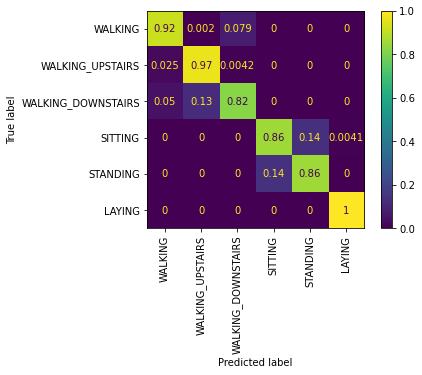

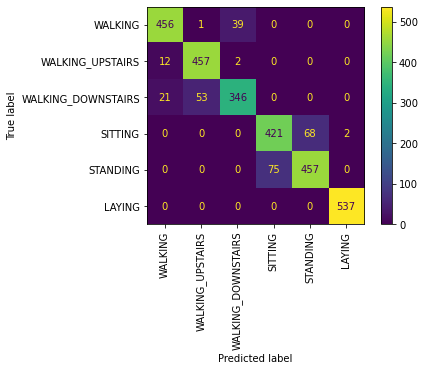

In [34]:
model1 = Pipeline([('thermometer', ThermometerEncoder(quantile_based=False)), 
                  ('wisard', WisardClassifier())])

model1.set_params(**best_params_model1)

train_and_evaluate_model(model1, train_eng, train_labels, test_eng, test_labels)

Training Accuracy: 0.9967
Test Accuracy: 0.9097


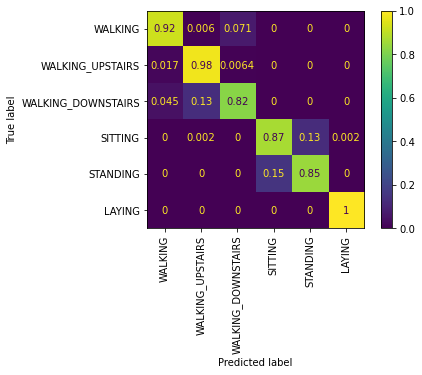

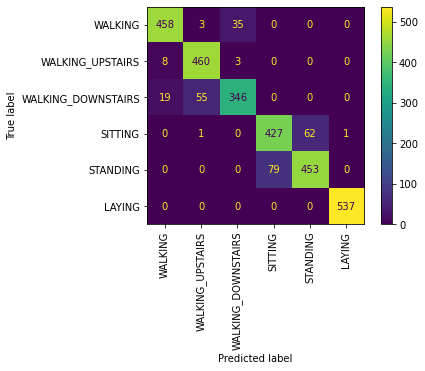

In [28]:
model1_2 = Pipeline([('thermometer', ThermometerEncoder(quantile_based=False)), 
                  ('wisard', WisardClassifier())])

model1_2.set_params(**best_params_model1_2)

train_and_evaluate_model(model1_2, train_eng, train_labels, test_eng, test_labels)

## 3.2. Model 2: WiSARD with quantile thermometer

This model uses Thermometer encoding with quantile based bins and the enginnered features to make the prediction.

In [35]:
def cross_validation_model2(X, y, n_splits=5, addressSize=[50], thermometer_size=[5], bleachingActivated=[True], 
                            thermometer_columns=None, quantile_based=[True]):
    grid_search_results = []
    best_params = None
    best_accuracy = -1
    
    if not thermometer_columns:
        thermometer_columns = list(range(X.shape[1]))
    
    param_grid_dict = dict()
    param_grid_dict['thermometer_size'] = thermometer_size
    param_grid_dict['addressSize'] = addressSize
    param_grid_dict['bleachingActivated'] = bleachingActivated
    param_grid_dict['quantile_based'] = quantile_based
    
    skf = StratifiedKFold(n_splits=n_splits)
    
    param_grid = ParameterGrid(param_grid_dict)
    
    param_grid_combinations = len(list(param_grid))
    n_combs = n_splits * param_grid_combinations
    progress = tqdm(total=n_combs, position=0, leave=True)
    
    for params in param_grid:
        print(params)
        training_time = []
        training_prediction_time = []
        validation_prediction_time = []
        thermometer_time = []
        training_accuracy = []
        validation_accuracy = []
        for train_index, val_index in skf.split(X, y):
            X_train = X[train_index, :]
            y_train = y[train_index]
            y_train_str = [str(l) for l in y_train]
            
            X_val = X[val_index, :]
            y_val = y[val_index]
            y_val_str = [str(l) for l in y_val]
            
            model = wp.Wisard(params['addressSize'], bleachingActivated=params['bleachingActivated'])
            thermometer = ThermometerEncoder(thermometer_columns, n_bits=params['thermometer_size'],
                                            quantile_based=params['quantile_based'])
            
            start = time()
            X_train = thermometer.fit_transform(X_train).astype(int).tolist()
            X_val = thermometer.transform(X_val).astype(int).tolist()
            end = time()
            thermometer_time.append(end-start)
            
            start = time()
            model.train(X_train, y_train_str)
            end = time()
            training_time.append(end-start)
            
            start = time()
            pred_train = model.classify(X_train)
            end = time()
            training_prediction_time.append(end-start)
            
            start = time()
            pred_val = model.classify(X_val)
            end = time()
            validation_prediction_time.append(end-start)
            
            training_accuracy.append(accuracy_score(y_train_str, pred_train))
            
            validation_accuracy.append(accuracy_score(y_val_str, pred_val))
            
            progress.update()
        
        cv_result = {'training_time_mean': np.mean(training_time),
                     'training_time_std': np.std(training_time),
                     'training_prediction_time_mean': np.mean(training_prediction_time),
                     'training_prediction_time_std': np.std(training_prediction_time),
                     'validation_prediction_time_mean': np.mean(validation_prediction_time),
                     'validation_prediction_time_std': np.std(validation_prediction_time),
                     'thermometer_time_mean': np.mean(thermometer_time),
                     'thermometer_time_std': np.std(thermometer_time),
                     'training_accuracy_mean': np.mean(training_accuracy),
                     'training_accuracy_std': np.std(training_accuracy),
                     'validation_accuracy_mean': np.mean(validation_accuracy),
                     'validation_accuracy_std': np.std(validation_accuracy)}
        
        cv_result = {**params, **cv_result}
        
        grid_search_results.append(cv_result)
        
        if (cv_result['validation_accuracy_mean'] > best_accuracy):
            best_accuracy = cv_result['validation_accuracy_mean']
            best_params = params
        
        print(f"Train acc. mean: {cv_result['training_accuracy_mean']:.4f} | Validation acc. mean: {cv_result['validation_accuracy_mean']:.4f}\n")
    
    grid_search_results = pd.DataFrame(grid_search_results)
    grid_search_results['rank'] = grid_search_results['validation_accuracy_mean'].rank(ascending=False)
    
    return grid_search_results, best_params

def cross_validation_model2(X, y, subjects, n_splits=5, addressSize=[50], 
                            bleachingActivated=[True], thermometer_size=[20], 
                            quantile_based=[True]):
    model = Pipeline([('thermometer', ThermometerEncoder()), 
                     ('wisard', WisardClassifier())])
    
    param_grid = [{'thermometer__n_bits': thermometer_size,
                   'thermometer__quantile_based': quantile_based,
                   'wisard__address_size': addressSize}]
    
    cv = GroupKFold(n_splits=n_splits)
    gs = GridSearchCV(model, param_grid, cv=cv, n_jobs=2, verbose=4)
    
    gs.fit(X, y, groups=subjects)
    
    return gs.cv_results_, gs.best_params_

In [36]:
addressSize = [8, 10, 12, 14, 16, 18]
thermometer_size = [40, 50, 60, 70, 80, 90]
gs_model2, best_params_model2 = cross_validation_model2(train_eng, train_labels, train_subjects, n_splits=5, 
                                                        addressSize=addressSize, thermometer_size=thermometer_size, 
                                                        bleachingActivated=[True, False], quantile_based=[True])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [37]:
with open('results/model2_best_params.pickle', 'wb') as file:
    pickle.dump(best_params_model2, file)
    
best_params_model2

{'thermometer__n_bits': 80,
 'thermometer__quantile_based': True,
 'wisard__address_size': 10}

In [38]:
gs_model2 = pd.DataFrame(gs_model2).sort_values('rank_test_score').reset_index(drop=True)

with open('results/model2_gs_results.pickle', 'wb') as file:
    pickle.dump(gs_model2, file)

gs_model2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_thermometer__n_bits,param_thermometer__quantile_based,param_wisard__address_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.499789,1.944940,11.102821,1.104562,80,True,10,"{'thermometer__n_bits': 80, 'thermometer__quan...",0.811972,0.897183,0.962597,0.936879,0.907418,0.903210,0.051066,1
1,18.419056,0.792026,11.328142,1.061058,80,True,12,"{'thermometer__n_bits': 80, 'thermometer__quan...",0.809155,0.900704,0.954834,0.939716,0.908605,0.902603,0.050750,2
2,16.020330,1.974298,11.402025,1.357966,70,True,8,"{'thermometer__n_bits': 70, 'thermometer__quan...",0.804225,0.892958,0.966831,0.935461,0.908012,0.901497,0.054771,3
3,6.806651,0.651978,4.464564,0.244882,40,True,10,"{'thermometer__n_bits': 40, 'thermometer__quan...",0.813380,0.898592,0.947071,0.938298,0.908012,0.901071,0.047425,4
4,9.559117,0.621906,6.160989,0.485238,50,True,10,"{'thermometer__n_bits': 50, 'thermometer__quan...",0.813380,0.893662,0.956951,0.936170,0.905045,0.901042,0.049224,5
5,27.583598,3.348984,14.435915,2.426086,90,True,14,"{'thermometer__n_bits': 90, 'thermometer__quan...",0.808451,0.897183,0.957657,0.936879,0.903858,0.900806,0.051157,6
6,19.890291,0.947774,10.935202,1.590028,80,True,14,"{'thermometer__n_bits': 80, 'thermometer__quan...",0.808451,0.890845,0.958363,0.941135,0.905045,0.900768,0.052127,7
7,18.527955,1.111412,12.990050,2.018017,80,True,8,"{'thermometer__n_bits': 80, 'thermometer__quan...",0.805634,0.898592,0.951306,0.937589,0.909792,0.900582,0.051081,8
8,23.047468,0.928216,13.545949,1.269136,90,True,10,"{'thermometer__n_bits': 90, 'thermometer__quan...",0.810563,0.893662,0.960480,0.937589,0.899703,0.900399,0.051204,9
9,11.080250,0.296432,8.110192,1.387651,60,True,12,"{'thermometer__n_bits': 60, 'thermometer__quan...",0.804930,0.899296,0.957657,0.929078,0.910979,0.900388,0.051630,10


In [34]:
with open('results/model2_gs_results.pickle', 'rb') as file:
    gs_model2 = pickle.load(file)

In [35]:
with open('results/model2_best_params.pickle', 'rb') as file:
    best_params_model2 = pickle.load(file)

Training Accuracy: 1.0000
Test Accuracy: 0.9260


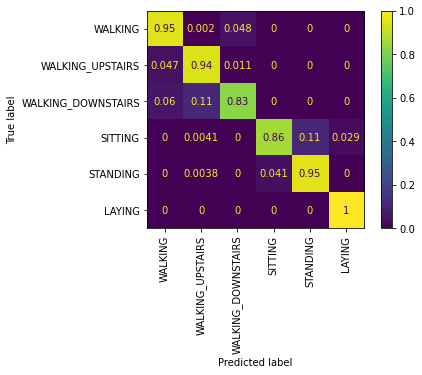

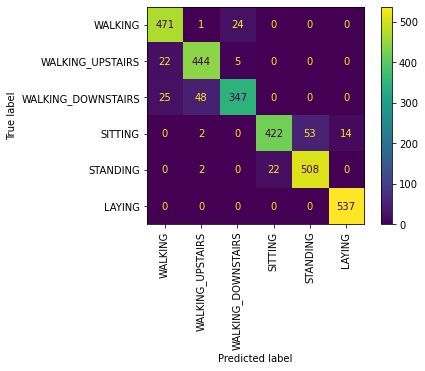

In [40]:
model2 = Pipeline([('thermometer', ThermometerEncoder()),
                   ('wisard', WisardClassifier())])

model2.set_params(**best_params_model2)

train_and_evaluate_model(model2, train_eng, train_labels, test_eng, test_labels)

## Model 4: Bagging wisard

In [27]:
def cross_validation_model4(X, y, subjects, n_splits=5, addressSize=[50], 
                            bleachingActivated=[True], thermometer_size=[20], 
                            quantile_based=[True], 
                            max_features=[0.8], max_samples=[0.8],
                            n_estimators=[10]):

    ensemble = BaggingClassifier(WisardClassifier(), n_jobs=1, verbose=1)
    
    model = Pipeline([('thermometer', ThermometerEncoder()), 
                     ('ensemble', ensemble)])
    
    param_grid = [{'thermometer__n_bits': thermometer_size,
                   'thermometer__quantile_based': quantile_based,
                   'ensemble__base_estimator__address_size': addressSize,
                   'ensemble__n_estimators': n_estimators,
                   'ensemble__max_features': max_features,
                   'ensemble__max_samples': max_samples}]
    
    cv = GroupKFold(n_splits=n_splits)
    gs = GridSearchCV(model, param_grid, cv=cv, n_jobs=1, verbose=4)
    
    gs.fit(X, y, groups=subjects)
    
    return gs.cv_results_, gs.best_params_

In [28]:
addressSize = [8]
thermometer_size = [60]
n_estimators = [10, 15, 20]
max_features = [0.8, 0.9, 1.0]
max_samples = [0.8, 0.9, 1.0]
gs_model4, best_params_model4 = cross_validation_model4(train_eng, train_labels, train_subjects, n_splits=5, 
                                                        addressSize=addressSize, thermometer_size=thermometer_size, 
                                                        bleachingActivated=[True, False], 
                                                        n_estimators=n_estimators,
                                                        max_features=max_features,
                                                        max_samples=max_samples)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.2s finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 2.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.4s finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 2.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.0s finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 2.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.7s finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 2.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 3.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 3.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 3.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 3.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 3.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 3.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.2min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.2min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.8, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.2min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=11.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=11.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=11.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=0.9, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=12.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.2min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.4min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.8, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 4.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 5.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 7.8min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 8.0min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=12.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=12.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=12.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=12.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=0.9, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=12.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.4min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.5min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=10, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 6.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.2min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time= 9.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.1min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.2min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=15, thermometer__n_bits=60, thermometer__quantile_based=True; total time=10.3min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished


[CV 1/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=13.6min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished


[CV 2/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=13.7min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished


[CV 3/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=13.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


[CV 4/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=13.9min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished


[CV 5/5] END ensemble__base_estimator__address_size=8, ensemble__max_features=1.0, ensemble__max_samples=1.0, ensemble__n_estimators=20, thermometer__n_bits=60, thermometer__quantile_based=True; total time=14.2min


C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished


In [29]:
with open('results/model4_best_params.pickle', 'wb') as file:
    pickle.dump(best_params_model4, file)
    
best_params_model4

{'ensemble__base_estimator__address_size': 8,
 'ensemble__max_features': 0.8,
 'ensemble__max_samples': 0.9,
 'ensemble__n_estimators': 15,
 'thermometer__n_bits': 60,
 'thermometer__quantile_based': True}

In [30]:
gs_model4 = pd.DataFrame(gs_model4).sort_values('rank_test_score').reset_index(drop=True)

with open('results/model4_gs_results.pickle', 'wb') as file:
    pickle.dump(gs_model4, file)

gs_model4

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ensemble__base_estimator__address_size,param_ensemble__max_features,param_ensemble__max_samples,param_ensemble__n_estimators,param_thermometer__n_bits,param_thermometer__quantile_based,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,220.618665,5.472168,105.341678,10.563803,8,0.8,0.9,15,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.809155,0.906338,0.959068,0.938298,0.908605,0.904293,0.051441,1
1,262.201365,5.916876,106.399475,10.091802,8,0.8,1,15,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.813380,0.901408,0.958363,0.937589,0.908605,0.903869,0.049645,2
2,222.922563,22.570282,87.268341,12.740411,8,0.9,1,10,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.809859,0.903521,0.956246,0.935461,0.910386,0.903095,0.050237,3
3,385.864331,9.377112,144.019772,11.560433,8,0.9,1,15,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.809155,0.900000,0.958363,0.938298,0.907418,0.902647,0.051275,4
4,344.957378,33.227657,145.967714,25.354244,8,1,0.9,15,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.807746,0.901408,0.956951,0.937589,0.909199,0.902579,0.051421,5
5,364.126276,7.501191,143.496356,12.244413,8,0.8,1,20,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.810563,0.898592,0.958363,0.936170,0.908605,0.902459,0.050516,6
6,229.251829,18.435776,96.706648,14.511416,8,1,0.9,10,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.806338,0.900000,0.958363,0.938298,0.906825,0.901965,0.052293,7
7,216.061001,31.432382,103.499908,12.199534,8,1,0.8,10,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.809155,0.900704,0.956951,0.940426,0.902077,0.901863,0.051221,8
8,269.805838,10.263349,133.518739,9.556536,8,0.9,0.8,15,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.807746,0.901408,0.956951,0.936879,0.906231,0.901843,0.051260,9
9,538.057930,7.978776,214.740129,17.216271,8,1,0.9,20,60,True,"{'ensemble__base_estimator__address_size': 8, ...",0.808451,0.902817,0.957657,0.931915,0.908012,0.901770,0.050558,10


In [ ]:
with open('results/model4_gs_results.pickle', 'rb') as file:
    gs_model4 = pickle.load(file)

In [ ]:
with open('results/model4_best_params.pickle', 'rb') as file:
    best_params_model4 = pickle.load(file)

C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\wisard\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min finished


Training Accuracy: 0.9974
Test Accuracy: 0.9250


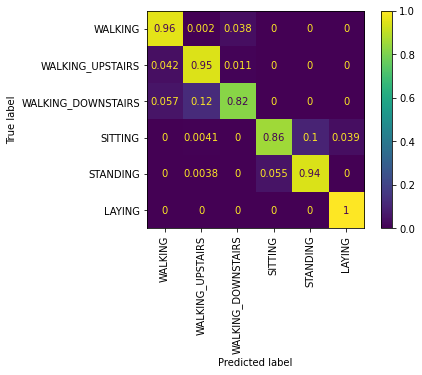

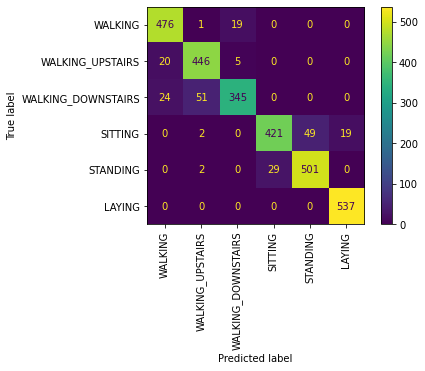

In [40]:
ensemble = BaggingClassifier(WisardClassifier(), n_jobs=1, verbose=1)
    
model4 = Pipeline([('thermometer', ThermometerEncoder()), 
                 ('ensemble', ensemble)])

model4.set_params(**best_params_model4)

train_and_evaluate_model(model4, train_eng, train_labels, test_eng, test_labels)